<a href="https://colab.research.google.com/github/ahmad123576/Deep-Learning/blob/main/spam_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.12.0 tensorflow-text==2.12.0 tensorflow-hub

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd
df = pd.read_csv('/content/spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df['Category'].value_counts()

,count
Category,
ham,4825
spam,747


In [4]:
747/4825


0.15481865284974095

In [5]:
# 15% are spam 85% are ham, dataset is imbalanced

In [6]:
# handle imbalance dataset with down_stamp
df_ham = df[df['Category'] == 'ham']
df_spam = df[df['Category'] == 'spam']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [7]:
df_balanced['Category'].value_counts()

,count
Category,
ham,747
spam,747


In [8]:
# balanced now

In [9]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
309,spam,TheMob> Check out our newest selection of cont...,1
2951,ham,Where are you ? You said you would be here whe...,0
180,ham,Hi! You just spoke to MANEESHA V. We'd like to...,0
4829,ham,Lol no. Just trying to make your day a little ...,0
998,ham,Not a lot has happened here. Feels very quiet....,0


In [10]:
# split it into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify = df_balanced['spam'])

In [11]:
X_train.head()

,Message
3557,Ok lor. I'm in town now lei.
734,Even u dont get in trouble while convincing..j...
4456,"Storming msg: Wen u lift d phne, u say ""HELLO""..."
5396,As in i want custom officer discount oh.
3988,Ringtone Club: Gr8 new polys direct to your mo...


In [12]:
# now lets import bert model
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [13]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    '500$ discount. hurry up',
    'Bhavin, are you up for a volleybal game tomorrow?'
]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [14]:
# get embedding vectors for few sample words
e = get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [15]:
# check cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
# banana vs grapes
cosine_similarity([e[0]], [e[1]])

array([[0.9911088]], dtype=float32)

In [16]:
cosine_similarity([e[0]], [e[3]])

array([[0.84703845]], dtype=float32)

In [17]:
cosine_similarity([e[3]], [e[4]])

array([[0.9872034]], dtype=float32)

In [18]:
# build a model(functional) in tensorflow

In [19]:
# bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# neural network
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# construct the final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
len(X_train)

1120

In [22]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [24]:
# train model
model.fit(X_train, y_train, epochs=2)

Epoch 1/2
35/35 [==============================] - 622s 17s/step - loss: 0.4030 - accuracy: 0.8670 - precision: 0.8525 - recall: 0.8875
Epoch 2/2
35/35 [==============================] - 574s 16s/step - loss: 0.3799 - accuracy: 0.8857 - precision: 0.8699 - recall: 0.9071


In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 193s 16s/step - loss: 0.3719 - accuracy: 0.8877 - precision: 0.8571 - recall: 0.9305


[0.3718801438808441,
 0.8877005577087402,
 0.8571428656578064,
 0.9304812550544739]

In [27]:
# to get pre-trained bert model to predict output for the input test data X_test
y_predicted = model.predict(X_test)
# 2d to 1d
y_predicted = y_predicted.flatten()

12/12 [==============================] - 205s 16s/step


In [28]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,

In [29]:
# get confusion matrics
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[158,  29],
       [ 13, 174]])

Text(50.722222222222214, 0.5, 'Truth')

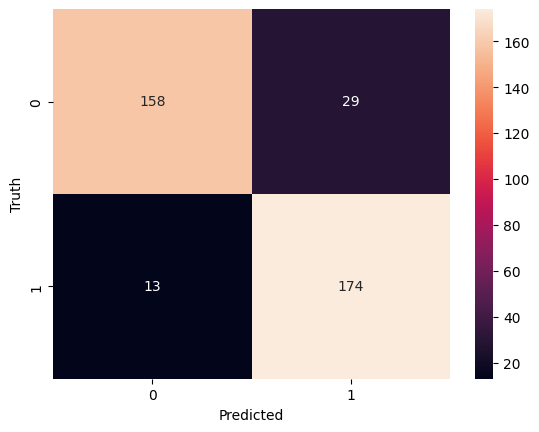

In [31]:
# plot
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True , fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       187
           1       0.86      0.93      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



In [34]:
# Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 5s 5s/step


array([[0.64862585],
       [0.71934277],
       [0.68941337],
       [0.28292137],
       [0.22901632]], dtype=float32)